## Training Word Embeddings from Scratch
This project walks through the steps to train word embedding using continuous bag-of-word model, introduced by Mikolov et al (2013) using numpy. The script is modified from a notebook used in the Natural Language Processing Specialization provided by deeplearning.ai.

In [2]:
# import libraries used.
#from bs4 import BeautifulSoup
from collections import defaultdict
from helper import get_batches
import nltk
import numpy as np
import pandas as pd
import re
from scipy import linalg



## Preprocessing: parsing xml file.
The wikipedia dump is saved using xml file format. Here we used the BeautifulSoup library to read in the file, selected only the content part of the dump (xml files have many tages) and converted the file to txt format for further processing.

In [3]:
# Parse xml file, extract text content and save as text file.
'''
with open('enwiki8.xml', 'r') as f:
    data = f.read()
    
    data_parsed = BeautifulSoup(data, "xml")
    text = data_parsed.find_all('text', attrs={'xml:space':'preserve'})
    df = pd.DataFrame({'Text': text})
    
    
    df = df.head(1000)
    
    #df['Text'] = df['Text'].replace('</text>', '', inplace = True)                                        
    
    df.to_csv('enwiki_small.txt', index = False, encoding = 'utf8', header = None, sep = ' ', mode = 'a')
'''

'\nwith open(\'enwiki8.xml\', \'r\') as f:\n    data = f.read()\n    \n    data_parsed = BeautifulSoup(data, "xml")\n    text = data_parsed.find_all(\'text\', attrs={\'xml:space\':\'preserve\'})\n    df = pd.DataFrame({\'Text\': text})\n    \n    \n    df = df.head(1000)\n    \n    #df[\'Text\'] = df[\'Text\'].replace(\'</text>\', \'\', inplace = True)                                        \n    \n    df.to_csv(\'enwiki_small.txt\', index = False, encoding = \'utf8\', header = None, sep = \' \', mode = \'a\')\n'

## Preprcessing: Read in words and Make Dictionary
Here, we first read in the words in the wikipedia content text file, keep only letters in the alphabet (lower case) and use these words to make a dictionary mapping each unique word to a number(index). This is because model only understands number.

In [4]:
# Load, tokenize and process the data

with open('enwiki_small.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Replace punctuations with .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Convert words into lower case ones and keep only letters.
print("Number of tokens:", len(data),'\n', data[:15])               

Number of tokens: 1049575 
 ['text', 'xml', 'preserve', 'redirect', 'aaa', 'text', 'xml', 'preserve', 'redirect', 'algeria', 'r', 'from', 'camelcase', 'text', 'xml']


The FreqDist function of nltk library is used to have a quick look on the most common words appeared in the document.

In [5]:
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  57912
Most frequent tokens:  [('.', 116643), ('the', 63035), ('of', 38865), ('and', 25787), ('in', 23088), ('to', 18489), ('a', 18466), ('is', 11367), ('as', 7759), ('by', 6811), ('was', 6734), ('for', 6661), ('that', 6575), ('with', 5767), ('on', 5328), ('it', 4662), ('are', 4584), ('from', 4496), ('or', 4424), ('his', 4290)]


In [6]:
# Iterate all words in the document to create two dictionaries:
# WordToInd_d: mapping unique word to number.
# IndToWord: mapping number to unique word.

WordToInd_d = dict()
IndToWord = dict()
WordInd = 0
for tok in data:
    if tok not in WordToInd_d:
        WordToInd_d[tok] = WordInd
        IndToWord[WordInd] = tok
        WordInd += 1
    
WordToInd_d['Unk'] = WordInd
IndToWord[WordInd] = 'Unk'

#print out the example of "you" in the dictionary
print(WordToInd_d['you'])   
print(IndToWord[858])   
  

858
you


## Model Buildup: Define Model Architecture
In this project, we start with a two-layer neural network model to train word embeddings. The dimension of the weight and biase matrices in the first and second layer is defined in the initialize_model funciton below.

In [7]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)    

    # The weight matrix of layer 1 (W1) is of size N by V, where 
    # N is the predefined dimension of hidden layer(a hyperparameter)
    # V is the size of the corpus(or the dictionary created above).
    W1 = np.random.rand(N,V)
    # The weight matrix of layer 2 (W2) is of shape (V,N)
    W2 = np.random.rand(V,N)
    # The bias matrix of layer 1 (W1) is of shape (N,1)
    b1 = np.random.rand(N,1)
    # The bias matrix of layer 2 (W2) is of shape (V,1)
    b2 = np.random.rand(V,1)


    return W1, W2, b1, b2

## Activation Function: Softmax
The activation function used for the final layer is softmax, defined below.

In [8]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    ### END CODE HERE ###
    
    return yhat

In [9]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    
    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    ### END CODE HERE ###

    return z, h

In [10]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [11]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    ### START CODE HERE (Replace instanes of 'None' with your code) ###
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T)    #1/m * relu(w2.T(yhat-y)) . xT
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    ### END CODE HERE ###
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [12]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, WordToInd_d, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        ### END CODE HERE ###
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [13]:
# test your function
C = 2
N = 50

V = len(WordToInd_d)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, WordToInd_d, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.148323
iters: 20 cost: 0.048244
iters: 30 cost: 0.028935
iters: 40 cost: 0.020685
iters: 50 cost: 0.016103
iters: 60 cost: 0.013186
iters: 70 cost: 0.011166
iters: 80 cost: 0.009683
iters: 90 cost: 0.008549
iters: 100 cost: 0.007653
iters: 110 cost: 0.007135
iters: 120 cost: 0.006703
iters: 130 cost: 0.006321
iters: 140 cost: 0.005980
iters: 150 cost: 0.005674


In [14]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [WordToInd_d[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [85, 5911, 5736, 265, 4585, 7221, 6245, 8074, 4701, 13912]


In [15]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T


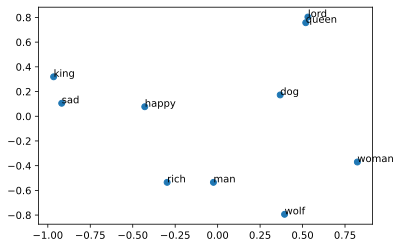

In [16]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

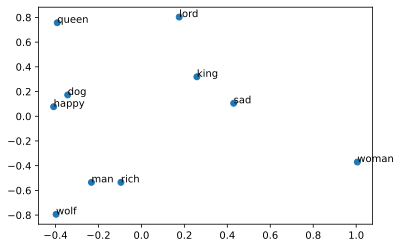

In [17]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()